# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы. 

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets torchinfo -q

# Imports and settings

In [2]:
import collections
import os
import random
import string
import time
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm.notebook as tqdm
%matplotlib inline

import datasets
import nltk
import nltk.tokenize
import sklearn
import sklearn.model_selection

import torch
import torch.nn
import torch.functional
import torch.utils.data as data_utils
import torchinfo

In [3]:
sns.set(style="darkgrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = (20, 20)

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/shaorrran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Setting random seeds for reproducibility

In [5]:
# Check CUDA version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [6]:
RANDOM_STATE = 42
def fix_seed(state):
    random.seed(state)
    os.environ["PYTHONHASHSEED"] = str(state)
    np.random.seed(state)
    torch.manual_seed(state)
    torch.cuda.manual_seed(state)
    torch.cuda.manual_seed_all(state)

fix_seed(RANDOM_STATE)

# Disable CuDNN benchmarking to eliminate related jitter. Will reduce performance a bit.
torch.backends.cudnn.benchmark = False
# See docs for torch.nn.RNN and torch.nn.LSTM for the rationale on using this workaround
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

# Set a Torch Generator with a fixed seed for more reproducibility
TORCH_RAND_GEN = torch.Generator()
TORCH_RAND_GEN.manual_seed(RANDOM_STATE)

# Determining available device

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

# Setting global variables

In [8]:
BATCH_SIZE = 96
WORD_THRESHOLD = 32
VOCAB_SIZE = 40000

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [9]:
dataset = datasets.load_dataset("imdb")

Found cached dataset imdb (/home/shaorrran/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

# Preprocessing

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать: 

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```. 
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [10]:
def create_sentences(dataset, threshold=WORD_THRESHOLD):
    sentences = []
    for i in tqdm.tqdm(dataset["train"]["text"], desc="Generating sentences", unit="sentences", unit_scale=False):
            sentences += [i.lower().replace("<br />", "").translate(str.maketrans("", "", string.punctuation)) 
                          for i in nltk.tokenize.sent_tokenize(i) 
                          if len(nltk.tokenize.word_tokenize(i)) < threshold]
    return sentences

sentences = create_sentences(dataset)

Generating sentences:   0%|          | 0/25000 [00:00<?, ?sentences/s]

In [11]:
print("Всего предложений:", len(sentences))

Всего предложений: 198801


Посчитаем для каждого слова его встречаемость.

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [12]:
def create_vocab(sentences, size=VOCAB_SIZE):
    words = collections.Counter()

    for sentence in tqdm.tqdm(sentences, desc="Creating vocabulary from sentences", unit="sentences", unit_scale=False):
        for word in nltk.tokenize.word_tokenize(sentence):
            words[word] += 1


    vocab = collections.OrderedDict.fromkeys(["<unk>", "<bos>", "<eos>", "<pad>"]) # ordered replacement for set
    
    for word, _ in tqdm.tqdm(words.most_common(size), desc="Selecting frequent words", unit="words", unit_scale=False):
        vocab[word] = None

    word2ind = {word: i for i, word in enumerate(vocab.keys())}
    ind2word = {i: word for word, i in word2ind.items()}

    return vocab, word2ind, ind2word

vocab, word2ind, ind2word = create_vocab(sentences)

Creating vocabulary from sentences:   0%|          | 0/198801 [00:00<?, ?sentences/s]

Selecting frequent words:   0%|          | 0/40000 [00:00<?, ?words/s]

In [13]:
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == VOCAB_SIZE + 4

In [14]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов). 

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```. 

In [15]:
class WordDataset(data_utils.Dataset):
    def __init__(self, sentences):
        super().__init__()
        self.data = sentences
        self.unk_id = word2ind["<unk>"]
        self.bos_id = word2ind["<bos>"]
        self.eos_id = word2ind["<eos>"]
        self.pad_id = word2ind["<pad>"]

    def __getitem__(self, idx: int) -> typing.List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in nltk.tokenize.word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [16]:
def collate_fn_with_padding(
    input_batch: typing.List[typing.List[int]], pad_id=word2ind["<pad>"]) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch)

    new_batch = {
        "input_ids": sequences[:,:-1],
        "target_ids": sequences[:,1:]
    }

    return new_batch

In [17]:
# The following function will use a fixed seed for DataLoader worker init
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    fix_seed(worker_seed)

In [18]:
train_sentences, eval_test_sentences = sklearn.model_selection.train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = sklearn.model_selection.train_test_split(eval_test_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

train_dataloader = data_utils.DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding,
    batch_size=BATCH_SIZE, num_workers=torch.multiprocessing.cpu_count(),
    worker_init_fn=seed_worker, generator=TORCH_RAND_GEN, pin_memory=True)

eval_dataloader = data_utils.DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding,
    batch_size=BATCH_SIZE, num_workers=torch.multiprocessing.cpu_count(),
    worker_init_fn=seed_worker, generator=TORCH_RAND_GEN, pin_memory=True)

test_dataloader = data_utils.DataLoader(
    test_dataset, shuffle=False, collate_fn=collate_fn_with_padding,
    batch_size=BATCH_SIZE, num_workers=torch.multiprocessing.cpu_count(),
    worker_init_fn=seed_worker, generator=TORCH_RAND_GEN, pin_memory=True)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве. 

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации. 
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве. 

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [19]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexities = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="Evaluating model", unit="batches", unit_scale=False):
            try:
                inputs, targets = batch["input_ids"].to(DEVICE), batch["target_ids"].to(DEVICE)
                logits = model(inputs).flatten(start_dim=0, end_dim=1)
                loss = criterion(logits, targets.flatten())
                perplexities.append(torch.exp(loss).item())
            finally:
                inputs, targets, logits = inputs.to("cpu"), targets.to("cpu"), logits.to("cpu")
                del inputs, targets, logits
                torch.cuda.empty_cache()

    return np.mean(perplexities)

### Train loop (1 балл)

Напишите функцию для обучения модели. 

In [20]:
def train_epoch(train_loader, model, optimizer, criterion, epoch, epochs_count):
    model.train()
    running_loss = 0.0
    processed = 0

    for batch in tqdm.tqdm(train_loader, desc=f"Fitting epoch {epoch + 1} / {epochs_count}", unit="batch(es)", unit_scale=False):
        try:
            input, labels = batch["input_ids"].to(DEVICE), batch["target_ids"].to(DEVICE)
            optimizer.zero_grad()
            output = model(input).flatten(start_dim=0, end_dim=1)
            loss = criterion(output, labels.flatten())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * input.size(0)
            processed += input.size(0)
        finally:
            input, labels, output = input.cpu(), labels.cpu(), output.cpu()
            del input, labels, output
            torch.cuda.empty_cache()

    return (running_loss / processed)

def eval_epoch(val_loader, model, criterion, epoch, epochs_count):
    model.eval()
    running_loss = 0.0
    processed = 0

    for batch in tqdm.tqdm(val_loader, desc=f"Evaluating epoch {epoch + 1} / {epochs_count}", unit="batch(es)", unit_scale=False):
        try:
            input, labels = batch["input_ids"].to(DEVICE), batch["target_ids"].to(DEVICE)
            with torch.no_grad():
                output = model(input).flatten(start_dim=0, end_dim=1)
                loss = criterion(output, labels.flatten())
                running_loss += loss.item() * input.size(0)
                processed += input.size(0)
        finally:
            input, output, labels = input.cpu(), output.cpu(), labels.cpu()
            del batch, output, labels
            torch.cuda.empty_cache()
        
    return (running_loss / processed)

In [21]:
def train(train_loader, val_loader, model, optimizer, criterion, epochs, scheduler=None, start_epoch=0):
    history = []
    start_time = time.time()

    for epoch in tqdm.tqdm(range(start_epoch, epochs), desc="Training", unit="epoch", unit_scale=False):
        try:
            train_loss = train_epoch(train_loader, model, optimizer, criterion, epoch, epochs)
            val_loss = eval_epoch(val_loader, model, criterion, epoch, epochs)

            if scheduler is not None:
                scheduler.step(val_loss)

            history.append((train_loss, val_loss, optimizer.param_groups[0]["lr"]))
        except KeyboardInterrupt as stop:
            tqdm.tqdm.write(f"Training interrupted at epoch {epoch + 1}. Returning history")
            return history

    end_time = time.time()
    train_time = end_time - start_time
    tqdm.tqdm.write(f"Overall training time: {train_time: 0.1f} seconds.")

    return history

In [22]:
def plot_loss(history):
    loss, val_loss, _ = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="Train loss", color="blue")
    plt.plot(val_loss, label="Validation loss", color="green")
    plt.legend(loc="best")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

def plot_learn_rate(history):
    _, _, learn_rates = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(learn_rates, label="Learn rate", color="red")
    plt.legend(loc="best")
    plt.xlabel("Epochs")
    plt.ylabel("Learn rate")
    plt.show()

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её. 

In [23]:
class BaselineLM(torch.nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, agg_type: str = "max", dropout_rate: float = 0.1):
        super().__init__()
        self.embed = torch.nn.Embedding(vocab_size, hidden_dim, padding_idx=word2ind["<pad>"])
        self.rnn = torch.nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.rnn = torch.nn.Sequential(collections.OrderedDict([
            ("embedding", torch.nn.Embedding(vocab_size, hidden_dim, padding_idx=word2ind["<pad>"])),
            ("rnn", torch.nn.RNN(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)),
        ]))
        self.fc0 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.act = torch.nn.Tanh()
        self.drop = torch.nn.Dropout(p=dropout_rate)
        self.fc1 = torch.nn.Linear(hidden_dim, vocab_size)
        self.fc = torch.nn.Sequential(collections.OrderedDict([
            ("fc0", torch.nn.Linear(hidden_dim, hidden_dim)),
            ("act0", torch.nn.Tanh()),
            ("drop", torch.nn.Dropout(p=dropout_rate)),
            ("fc1", torch.nn.Linear(hidden_dim, vocab_size))
        ]))

    def forward(self, input):
        output, _ = self.rnn(input)
        return self.fc(output)

In [24]:
model = BaselineLM(hidden_dim=256, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model.parameters())

In [25]:
torchinfo.summary(
    model,
    (BATCH_SIZE, WORD_THRESHOLD - 1),
    dtypes=[torch.long]
)

Layer (type:depth-idx)                   Output Shape              Param #
BaselineLM                               [96, 31, 40004]           20,587,844
├─Sequential: 1-1                        [96, 31, 256]             --
│    └─Embedding: 2-1                    [96, 31, 256]             10,241,024
│    └─RNN: 2-2                          [96, 31, 256]             131,584
├─Sequential: 1-2                        [96, 31, 40004]           --
│    └─Linear: 2-3                       [96, 31, 256]             65,792
│    └─Tanh: 2-4                         [96, 31, 256]             --
│    └─Dropout: 2-5                      [96, 31, 256]             --
│    └─Linear: 2-6                       [96, 31, 40004]           10,281,028
Total params: 41,307,272
Trainable params: 41,307,272
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.37
Input size (MB): 0.02
Forward/backward pass size (MB): 970.70
Params size (MB): 82.88
Estimated Total Size (MB): 1053.60

In [26]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=10)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Fitting epoch 1 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 1 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 2 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 2 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 3 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 3 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 4 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 4 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 5 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 5 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 6 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 6 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 7 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 7 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 8 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 8 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 9 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 9 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 10 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 10 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Overall training time:  4172.4 seconds.


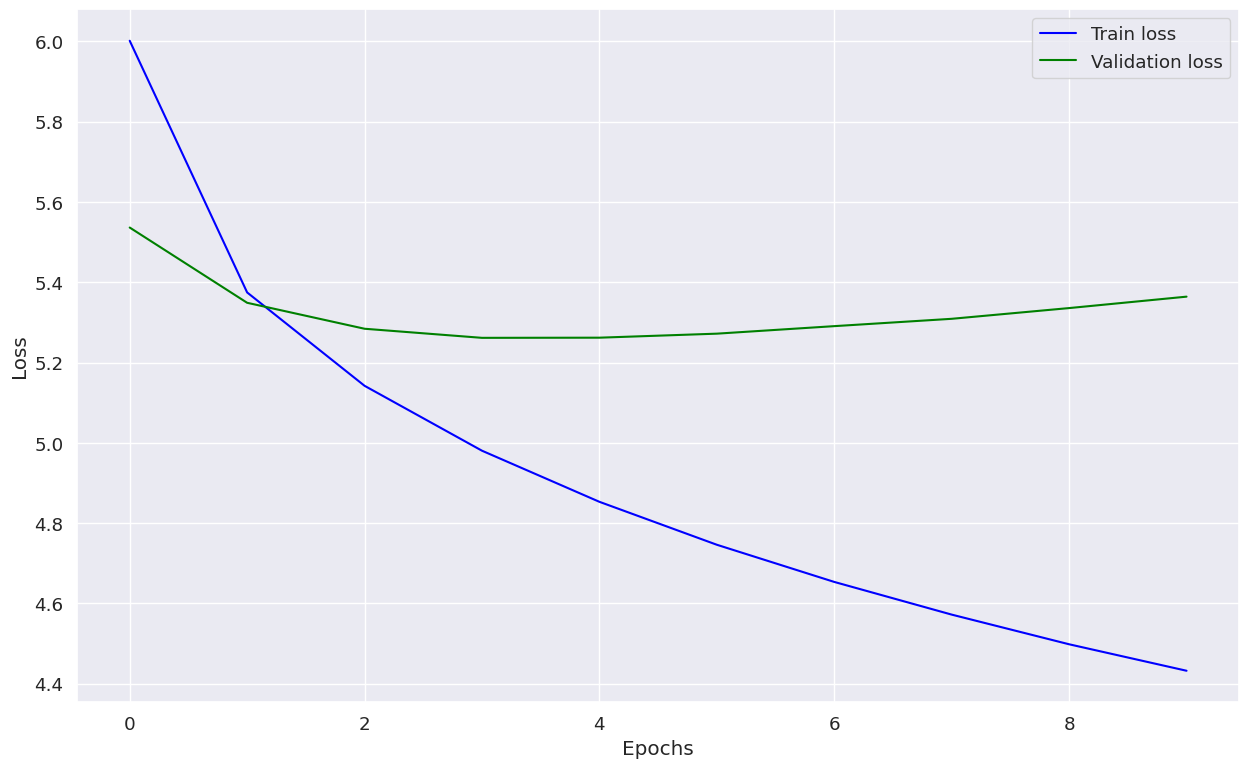

In [27]:
plot_loss(history)

In [28]:
baseline_metric = evaluate(model, criterion, eval_dataloader)
print(f"Baseline perplexity: {baseline_metric}")

Evaluating model:   0%|          | 0/208 [00:00<?, ?batches/s]

Baseline perplexity: 214.94239689753607


In [29]:
model = model.to("cpu")
del model
torch.cuda.empty_cache()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше. 

In [30]:
class LSTMLM(torch.nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, agg_type: str = "max", dropout_rate: float = 0.1):
        super().__init__()
        self.rnn = torch.nn.Sequential(collections.OrderedDict([
            ("embedding", torch.nn.Embedding(vocab_size, hidden_dim)),
            ("lstm", torch.nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)),
        ]))
        self.fc = torch.nn.Sequential(collections.OrderedDict([
            ("fc0", torch.nn.Linear(hidden_dim, hidden_dim)),
            ("act0", torch.nn.Tanh()),
            ("drop", torch.nn.Dropout(p=dropout_rate)),
            ("fc1", torch.nn.Linear(hidden_dim, vocab_size))
        ]))

    def forward(self, input):
        output, _ = self.rnn(input)
        return self.fc(output)

In [31]:
model = LSTMLM(hidden_dim=256, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model.parameters())

In [32]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=10)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Fitting epoch 1 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 1 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 2 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 2 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 3 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 3 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 4 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 4 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 5 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 5 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 6 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 6 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 7 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 7 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 8 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 8 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 9 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 9 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 10 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 10 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Overall training time:  4235.1 seconds.


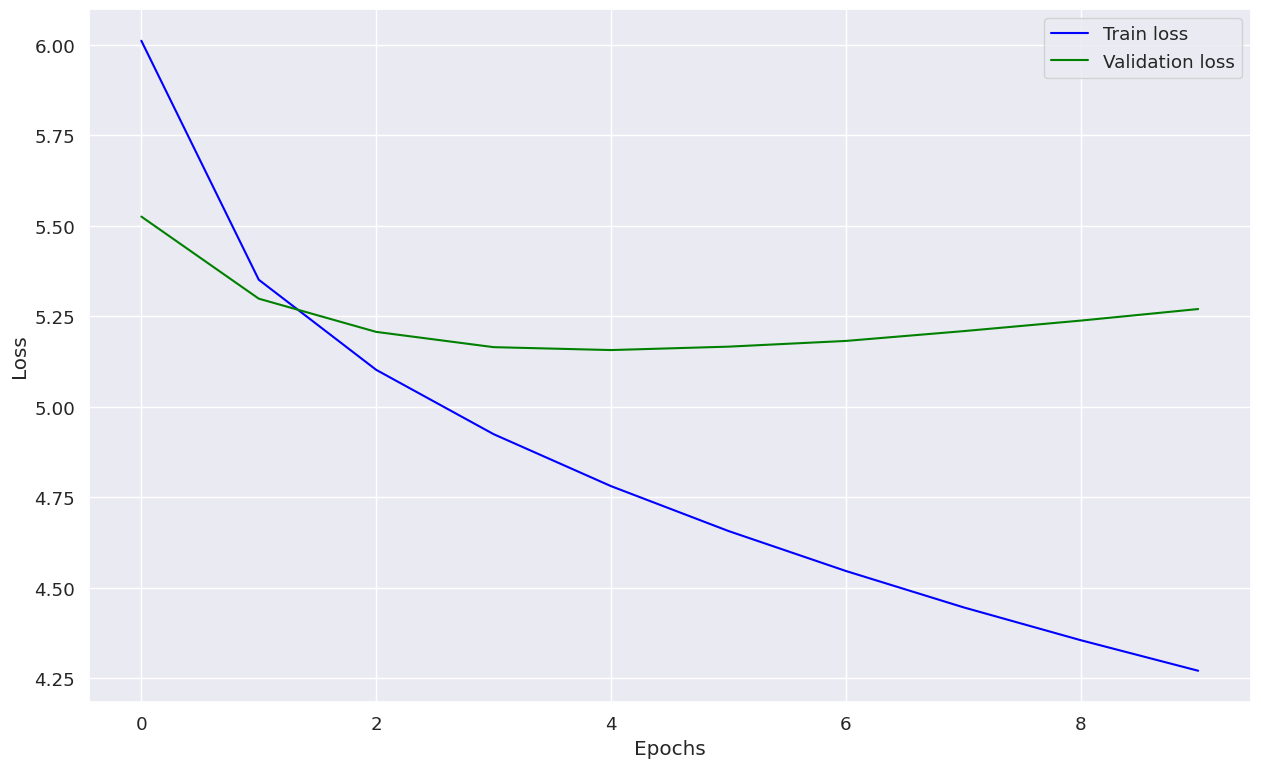

In [33]:
plot_loss(history)

In [34]:
lstm_metric = evaluate(model, criterion, eval_dataloader)
print(f"LSTM perplexity: {lstm_metric}")

Evaluating model:   0%|          | 0/208 [00:00<?, ?batches/s]

LSTM perplexity: 195.89662053034857


In [35]:
model = model.cpu()
del model
torch.cuda.empty_cache()

### Training with different LR

In [36]:
model = LSTMLM(hidden_dim=256, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [37]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=10)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Fitting epoch 1 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 1 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 2 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 2 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 3 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 3 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 4 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 4 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 5 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 5 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 6 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 6 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 7 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 7 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 8 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 8 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 9 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 9 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 10 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 10 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Overall training time:  4197.5 seconds.


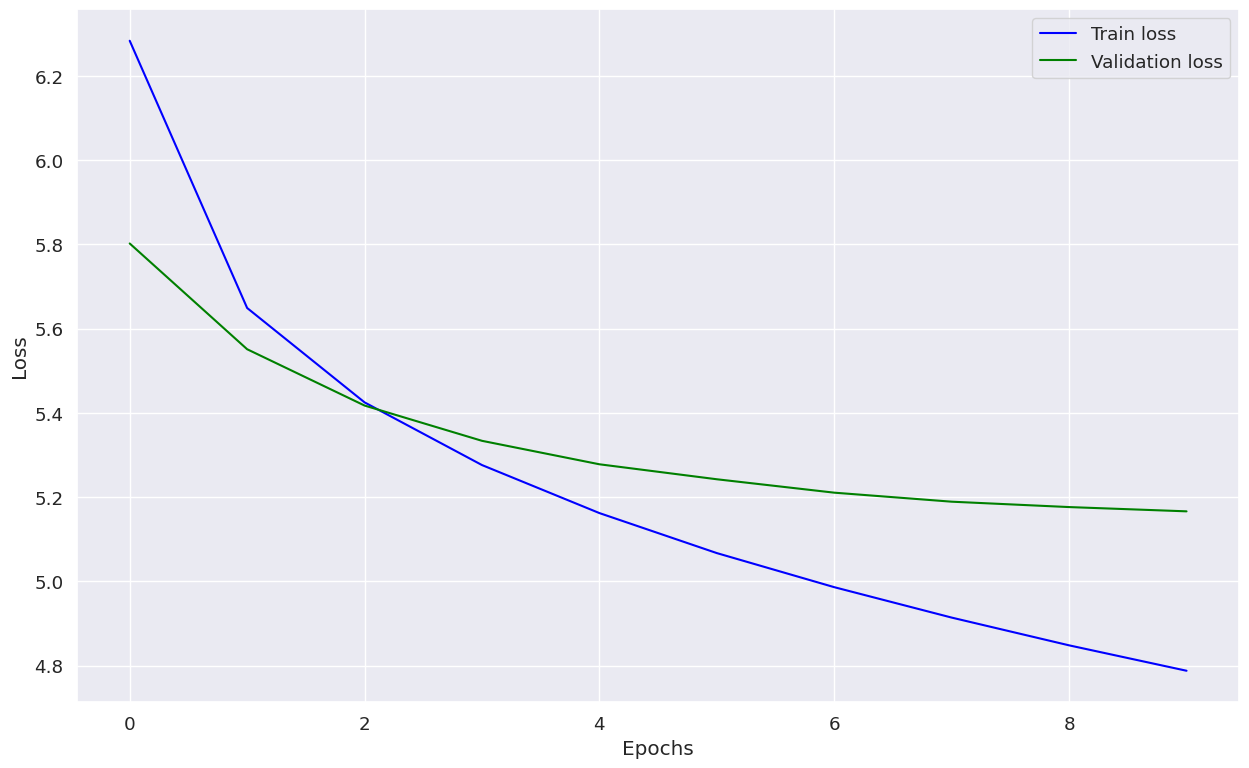

In [38]:
plot_loss(history)

In [39]:
lstm_karpathy_metric = evaluate(model, criterion, eval_dataloader)
print(f"LSTM perplexity (lr=3e-4): {lstm_karpathy_metric}")

Evaluating model:   0%|          | 0/208 [00:00<?, ?batches/s]

LSTM perplexity (lr=3e-4): 176.04985369168796


In [40]:
model = model.cpu()
del model
torch.cuda.empty_cache()

# Setting hidden state size

In [41]:
model = LSTMLM(hidden_dim=512, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [42]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=10)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Fitting epoch 1 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 1 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 2 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 2 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 3 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 3 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 4 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 4 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 5 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 5 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 6 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 6 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 7 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 7 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 8 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 8 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 9 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 9 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Fitting epoch 10 / 10:   0%|          | 0/1657 [00:00<?, ?batch(es)/s]

Evaluating epoch 10 / 10:   0%|          | 0/208 [00:00<?, ?batch(es)/s]

Overall training time:  6186.4 seconds.


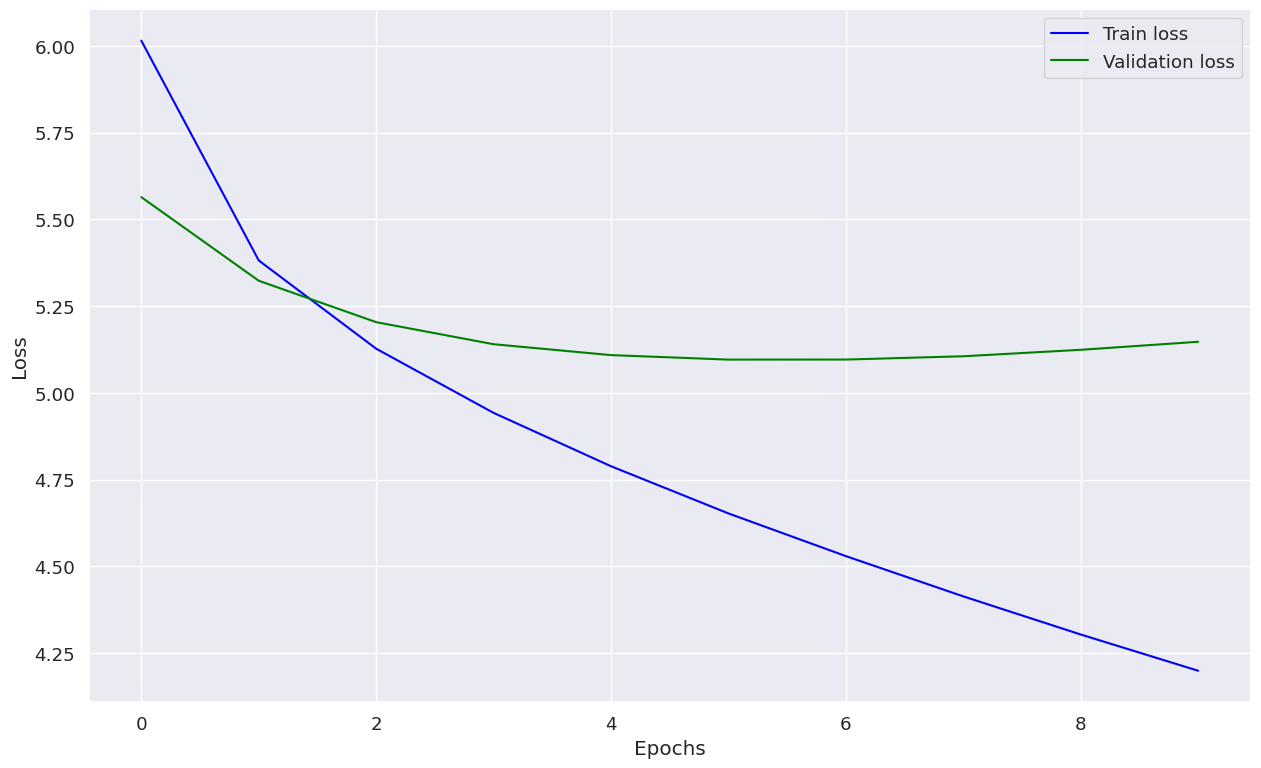

In [43]:
plot_loss(history)

In [44]:
lstm_512_metric = evaluate(model, criterion, eval_dataloader)
print(f"LSTM perplexity (lr=3e-4, hidden_dim=512): {lstm_512_metric}")

Evaluating model:   0%|          | 0/208 [00:00<?, ?batches/s]

LSTM perplexity (lr=3e-4, hidden_dim=512): 172.96553369668814


# Training to convergence


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей. 

In [49]:
import pandas as pd
summary_table = pd.DataFrame({"Name": ["Baseline", "LSTM", "LSTM, lr=3e-4", "LSTM hidden_dim=512"], 
                              "Perplexity": [baseline_metric, lstm_metric, lstm_karpathy_metric, lstm_512_metric]})
summary_table

,Name,Perplexity
0,Baseline,214.942397
1,LSTM,195.896621
2,"LSTM, lr=3e-4",176.049854
3,LSTM hidden_dim=512,172.965534


<Axes: xlabel='Name'>

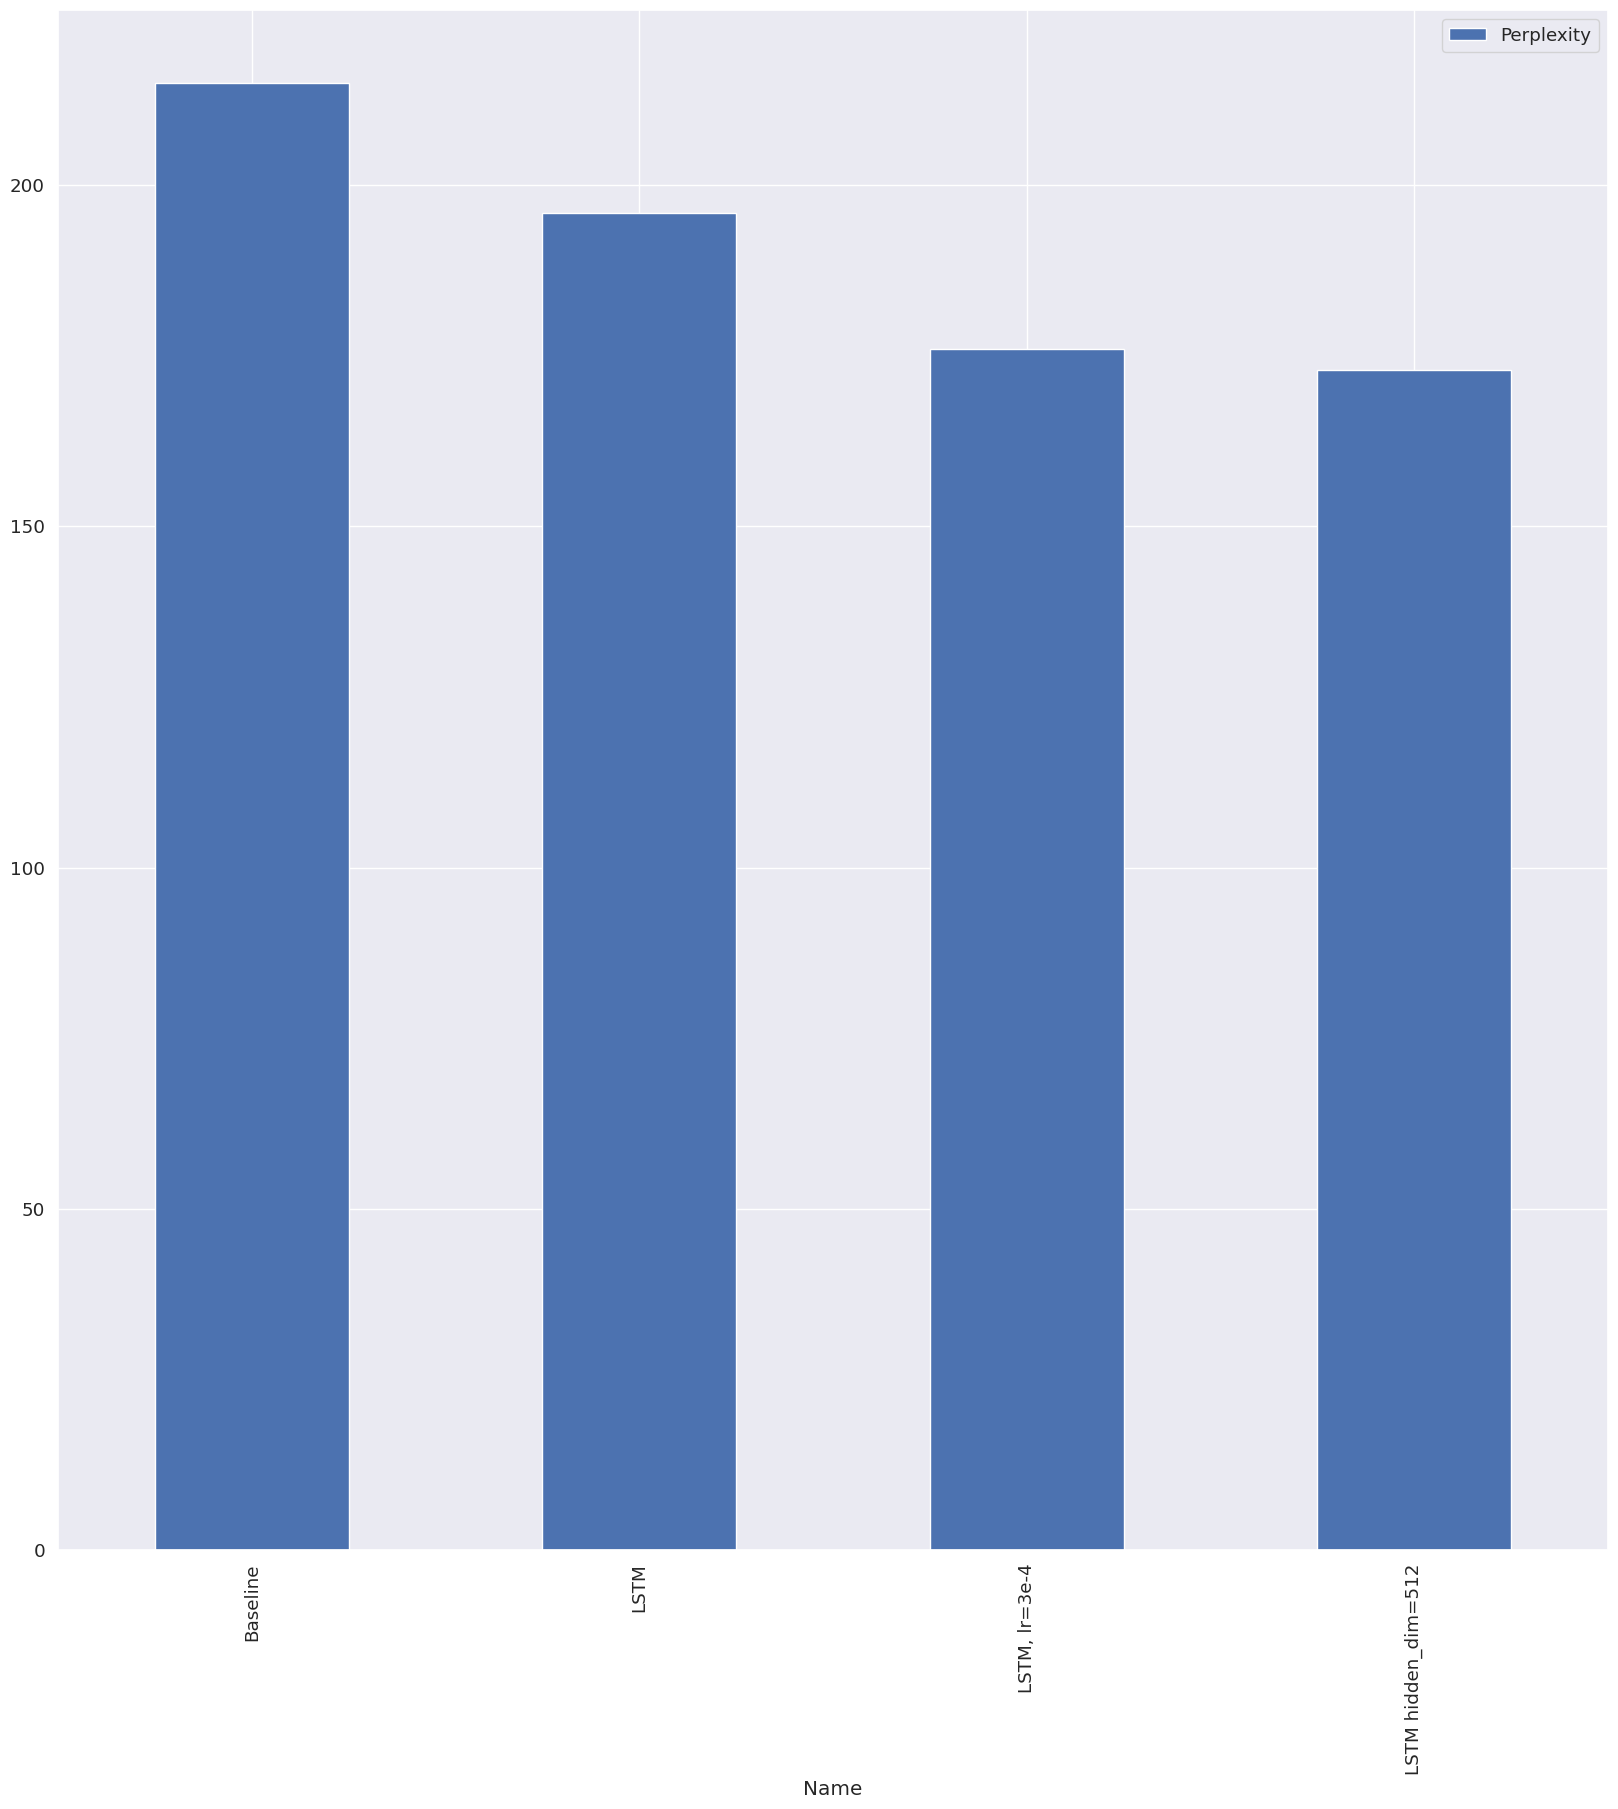

In [53]:
summary_table.plot(kind="bar", x="Name", y="Perplexity")

Как видно из графика, перплексия становилась ниже с каждым новым экспериментом, причём наибольшее влияние оказали переход на LSTM и снижение learn_rate.

Из графиков лоссов во время обучения (показаны после обучения каждой модели) видно, что модель начинает переобучаться в большинстве случаев примерно на 4-5 эпохе. Возможно, стоит попробовать добавить `BatchNorm` или попробовать изменять learn rate.



Примечание: модели обучаются невероятно долго, причём во время работы над экспериментами было установлено, что большую часть времени (почти 7 секунд при размере батча в 512!) занимает forward pass в последнем линейном слое.